In [0]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers

**The Kernel trick.** 

The Kernel trick. provides a bridge from linearity to non-linearity to any algorithm that can expressed solely on terms of dot products between two vectors. With this method we first map our input data into a higher-dimensional space, a linear algorithm operating in this space will behave non-linearly in the original input space.

Kernel functions must be continuous, symmetric, and most preferably should have a positive (semi-) definite Gram matrix. Kernels which are said to satisfy the Mercer’s theorem (which polynomial and linear kerles do) are positive semi-definite, meaning their kernel matrices have only non-negative Eigen values. The use of a positive definite kernel means that the optimization problem will be convex and solution will be unique. 

---

**Polynomial Kernel.**

The Polynomial kernel is a non-stationary kernel. Polynomial kernels are well suited for problems where all the training data is normalized.

$k(x, y) = (\alpha x^T y + c)^d$

Adjustable parameters are the slope $\alpha$, the constant term c and the polynomial degree d. In this case I use 3 degree polynomial. 

In [0]:
class PolynomialKernel(object):

    def kernel(self, x, y, p=3):
        return (1 + np.dot(x, y)) ** p

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])
        # print("X", X)
        # print("Gram matrix X", K)
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h = cvxopt.matrix(np.zeros(n_samples))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Метод множителей Лагранжа
        a = np.ravel(solution['x'])
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

    def evaluate(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                s += a * sv_y * self.kernel(X[i], sv)
            y_predict[i] = s
        return y_predict + self.b

In [0]:

import pylab as pl


def generate_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2


def split_train(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train

def split_test(X1, y1, X2, y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test


def plot_contour(X1_train, X2_train, clf):
    pl.plot(X1_train[:,0], X1_train[:,1], "bo")
    pl.plot(X2_train[:,0], X2_train[:,1], "mo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="k")

    X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = clf.evaluate(X).reshape(X1.shape)
    pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    pl.axis("tight")
    pl.show()

def test_non_linear():
    X1, y1, X2, y2 = generate_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = PolynomialKernel()
    clf.fit(X_train, y_train)

    y_predict = np.sign(clf.evaluate(X_test))
    correct = np.sum(y_predict == y_test)
    print("%d support vectors" % (len(clf.a)))
    print("%d/%d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)



     pcost       dcost       gap    pres   dres
 0: -3.7735e+01 -8.3878e+01  1e+03  4e+01  2e+00
 1: -7.5524e+01 -6.7841e+01  5e+02  2e+01  9e-01
 2: -1.3321e+01 -2.8446e+00  1e+02  3e+00  2e-01
 3: -5.8310e-01 -5.4557e-01  5e+00  1e-01  8e-03
 4: -1.9977e-01 -5.4222e-01  3e+00  6e-02  4e-03
 5: -1.0672e-01 -4.0754e-01  1e+00  2e-02  1e-03
 6: -1.3542e-01 -2.7075e-01  4e-01  7e-03  4e-04
 7: -1.4969e-01 -2.0855e-01  2e-01  3e-03  2e-04
 8: -1.4691e-01 -1.8269e-01  1e-01  1e-03  6e-05
 9: -1.3594e-01 -1.8640e-01  9e-02  6e-04  4e-05
10: -1.6130e-01 -1.7311e-01  2e-02  1e-04  6e-06
11: -1.6739e-01 -1.7154e-01  5e-03  2e-05  1e-06
12: -1.7075e-01 -1.7102e-01  3e-04  2e-07  1e-08
13: -1.7100e-01 -1.7100e-01  3e-06  2e-09  1e-10
14: -1.7100e-01 -1.7100e-01  3e-08  2e-11  1e-12
Optimal solution found.
9 support vectors
19/20 predictions correct


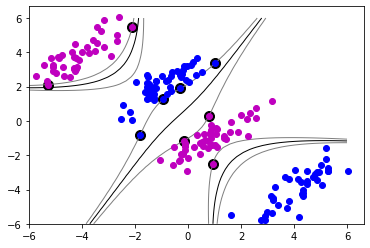

In [111]:
test_non_linear()